# Transformador Personal.
EL7850-1 Trabajo de Investigación Dirigido

Autor: José Rubio

Profesor: Pablo Estévez


## Adaptacion de modelo Transformer decoder

In [ ]:
# !pip install icecream
!pip install helpers
!pip install plot

     |████████████████████████████████| 135 kB 13.5 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=5610649e3c06d2891b67895f361e041088c4ed78ff7fc8106a182e4fdcd96bb8
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


## Librerías

In [ ]:
import pandas as pd
import time
import numpy as np
import datetime
import torch, math, random
import torch.nn as nn
import matplotlib.pyplot as plt
import logging
import os, shutil
import argparse

from joblib import load
from joblib import dump
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

## Modelo

In [ ]:
"""
The architecture is based on the paper “Attention Is All You Need”. 
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017.
"""

class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size, n_heads, dim_ff_enc, num_layers, dropout=0):
        super(Transformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=n_heads, dim_feedforward=dim_ff_enc, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src,mask)
        output = self.decoder(output)
        return output

## Prueba del modelo con datos sinteticos

Al tener el modelo, entonces se quiere analizar el rendimiento de este utilizando datos sintetícos (función seno). Para ello se crea el objeto SinteticDataset

### Función de positional enconding

La función definida incorpora valores posicionales a la data de demanda horaria, permitiendo el proceso a los modulos de atención.

In [ ]:
def df_date_encoding(df):

    df_process = df.copy()
    timestamps = df_process['time']
    timestamps_hour = np.array([t.hour for t in timestamps])
    timestamps_day = np.array([t.day for t in timestamps])
    timestamps_month = np.array([t.month for t in timestamps])
 
    hours_in_day = 24
    days_in_month = 30
    month_in_year = 12

    df_process['sin_hour'] = np.sin(2*np.pi*timestamps_hour/hours_in_day)
    df_process['cos_hour'] = np.cos(2*np.pi*timestamps_hour/hours_in_day)
    df_process['sin_day'] = np.sin(2*np.pi*timestamps_day/days_in_month)
    df_process['cos_day'] = np.cos(2*np.pi*timestamps_day/days_in_month)
    df_process['sin_month'] = np.sin(2*np.pi*timestamps_month/month_in_year)
    df_process['cos_month'] = np.cos(2*np.pi*timestamps_month/month_in_year)

    return df_process

### Configuración del generador de datos sintéticos.

Este objeto genera datos periodicos que siguen la forma de una función seno. La cantidad total de datos y la frecuencia de este se puede controlar en la inicialización de este (esta se controla decidiendo la cantidad de puntos que se quiere por ciclo, mientras este valor sea mas cercano a la cantidad total de puntos generados entonces la frecuencia será menor)

In [ ]:
class SinteticDataset(Dataset):
    """ Sintetic data to transformer, sin or cos """

    def __init__(self, length, points_day, training_length, forecast_window, n_reset=1):
        """
        Args:
            length: Quantity of sintetic points generated.
            points_day: Frequency points generated by day.
            n_reset: Quantity of resets of series generated in getitem atribute.
            training_length: reason size of the total data that is used to train the system.
            forecast_window: Window of predictions.
        """

        reason = length/points_day
        data_generated = np.linspace(0, reason*360, length)
        data_sin  = np.sin(data_generated*np.pi/180)
        df = pd.DataFrame(data_sin, columns={'sintetic_data'})
        df['time'] = pd.date_range(start='2020-01-01 00:00:00', periods=len(df), freq='H')
        df = df_date_encoding(df)

        self.df = df
        self.n = n_reset
        self.T = training_length
        self.S = forecast_window

        self.transform = MinMaxScaler()

    def __len__(self):
        return self.n

    
    def __getitem__(self, idx):
        # The idx indicates the times of resets that be explored in the epoch.
        
        # np.random.seed(0)

        start = np.random.randint(0, len(self.df) - self.T - self.S) 
        index_in = torch.tensor([i for i in range(start, start+self.T)])
        index_tar = torch.tensor([i for i in range(start + self.T, start + self.T + self.S)])
        features = ['sintetic_data', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month']
        _input = torch.tensor(self.df[features][start : start + self.T].values)
        target = torch.tensor(self.df[features][start + self.T : start + self.T + self.S].values)

        # scalar input/output of shape: [n_samples, n_features].
        scaler = self.transform

        scaler.fit(_input[:,0].unsqueeze(-1))
        _input[:,0] = torch.tensor(scaler.transform(_input[:,0].unsqueeze(-1)).squeeze(-1))
        target[:,0] = torch.tensor(scaler.transform(target[:,0].unsqueeze(-1)).squeeze(-1))

        # save the scalar to be used later when inverse translating the data for plotting.
        dump(scaler, 'scalar_item.joblib')

        return index_in, index_tar, _input, target

In [ ]:
length = 450
points_cycle = 50
training_length = 72
forecast_window = 48

train_dataset = SinteticDataset(length=length, points_day=points_cycle, training_length=training_length, forecast_window=forecast_window)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

###Función de entrenamiento

Este bloque contiene el entrenamiento del modelo, cabe destacar que la cantidad de datos utilizados para el entrenamiento y la ventana de predicción se deben configurar previamente en el objeto generador de datos. Este sistema puede realizar entrenamientos para realizar predicciones one step o sampling, las cuales toma valores predichos como entradas para darle diversificación al entrenamiento.

In [ ]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s %(message)s", datefmt="[%Y-%m-%d %H:%M:%S]")
logger = logging.getLogger(__name__)

def flip_from_probability(p):
    return True if random.random() < p else False

def train_transformer(dataloader, EPOCH, train_method, k, feature_size, n_heads, dim_ff_enc, encoder_layers, path_to_save_model,
                      path_to_save_loss, path_to_save_predictions, device, xlabel_train, ylabel_train, title_train):

    device = torch.device(device)

    model = Transformer(feature_size=feature_size, n_heads=n_heads, dim_ff_enc=dim_ff_enc, num_layers=encoder_layers).double().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200)
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf')

    for epoch in range(EPOCH + 1):
        train_loss = 0

        model.train()
        for index_in, index_tar, _input, target in dataloader:

            optimizer.zero_grad()
            src = _input.permute(1,0,2).double().to(device)[:-1,:,:] # Cambio de las dimensiones para el procesamiento del modelo
            target = _input.permute(1,0,2).double().to(device)[1:,:,:] # src shifted by 1.

            # Entrenamiento one step
            if train_method == 'one_step':
                prediction = model(src, device)
                loss = criterion(prediction, target[:,:,0].unsqueeze(-1))
            
            # Entrenamiento con muestreo de predicciones anteriores.
            elif train_method == 'sampling':
                sampled_src = src[:1, :, :] #t0 torch.Size([1, 1, 7])
                for i in range(len(target)-1):

                  prediction = model(sampled_src, device) 

                  if i < 24: # One day, enough data to make inferences about cycles
                      prob_true_val = True
                  else:
                      ## coin flip
                      v = k/(k+math.exp(epoch/k)) # probability of heads/tails depends on the epoch, evolves with time.
                      prob_true_val = flip_from_probability(v) # starts with over 95 % probability of true val for each flip in epoch 0.
                      ## if using true value as new value

                  if prob_true_val: # Using true value as next value
                      sampled_src = torch.cat((sampled_src.detach(), src[i+1, :, :].unsqueeze(0).detach()))
                  else: ## using prediction as new value
                      positional_encodings_new_val = src[i+1,:,1:].unsqueeze(0)
                      predicted_humidity = torch.cat((prediction[-1,:,:].unsqueeze(0), positional_encodings_new_val), dim=2)
                      sampled_src = torch.cat((sampled_src.detach(), predicted_humidity.detach()))
                
                loss = criterion(target[:-1,:,0].unsqueeze(-1), prediction)
            
            """To update model after each sequence"""

            # loss = criterion(target[:-1,:,0].unsqueeze(-1), prediction)
            # loss = criterion(prediction, target[:,:,0].unsqueeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()

        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + f"best_train_{epoch}.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer_{epoch}.pth")
            min_train_loss = train_loss
            best_model = f"best_train_{epoch}.pth"


        length_plot = 200

        if epoch % 100 == 0 and train_method == 'one_step': # Plot 1-Step Predictions

            logger.info(f"Epoch: {epoch}, Training loss: {train_loss}")
            scaler = load('scalar_item.joblib')
            src_init = scaler.inverse_transform(src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            prediction = scaler.inverse_transform(prediction[:,:,0].detach().cpu().numpy()) #torch.Size([35, 1, 7])
            src_to_plot, pred_to_plot = src_init[:length_plot], prediction[:length_plot]
            index_in_plot, index_tar_plot = index_in[:length_plot], index_tar[:length_plot]
            plot_training(epoch, path_to_save_predictions, src_to_plot, pred_to_plot, index_in, index_tar, xlabel_train, 
                            ylabel_train, title_train)

        if epoch % 10 == 0 and train_method == 'sampling': # Plot 1-Step Predictions

            logger.info(f"Epoch: {epoch}, Training loss: {train_loss}")
            scaler = load('scalar_item.joblib')
            sampled_src_humidity = scaler.inverse_transform(sampled_src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            src_init = scaler.inverse_transform(src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            prediction = scaler.inverse_transform(prediction[:,:,0].detach().cpu().numpy()) #torch.Size([35, 1, 7])
            plot_training_3(epoch, path_to_save_predictions, src_init, sampled_src_humidity, prediction, index_in, index_tar,
                            xlabel_train, ylabel_train, title_train)

        train_loss /= len(dataloader)
        log_loss(train_loss, path_to_save_loss, train=True)
        
    plot_loss(path_to_save_loss, train=True)
    return best_model

### Función de carga y predicción de modelos

Este bloque contiene un sistema que carga un modelo previamente entrenado, ademas a partir de esto genera gráficos para ver con detalle cuales son las predicciones realizadas por el sistema

In [ ]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s %(message)s", datefmt="[%Y-%m-%d %H:%M:%S]")
logger = logging.getLogger(__name__)

def inference(path_to_save_predictions, inference_rounds, feature_size, n_heads, dim_ff_enc, encoder_layers, 
              forecast_window, dataloader, device, path_to_save_model, best_model, xlabel, ylabel, title):

    device = torch.device(device)
    
    model = Transformer(feature_size=feature_size, n_heads=n_heads, dim_ff_enc=dim_ff_enc, num_layers=encoder_layers).double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+best_model))
    criterion = torch.nn.MSELoss()

    val_loss = 0
    with torch.no_grad():

        model.eval()
        mape_sum = 0
        mae_sum = 0
        for round in range(inference_rounds):

            for index_in, index_tar, _input, target in dataloader:
                
                # starting from 1 so that src matches with target, but has same length as when training
                src = _input.permute(1,0,2).double().to(device)[1:, :, :] # 47, 1, 7: t1 -- t47
                target = target.permute(1,0,2).double().to(device) # t48 - t59

                next_input_model = src
                all_predictions = []

                for i in range(forecast_window - 1):
                    
                    prediction = model(next_input_model, device) # 47,1,1: t2' - t48'

                    if all_predictions == []:
                        all_predictions = prediction # 47,1,1: t2' - t48'
                    else:
                        all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0))) # 47+,1,1: t2' - t48', t49', t50'

                    pos_encoding_old_vals = src[i+1:, :, 1:] # 46, 1, 6, pop positional encoding first value: t2 -- t47
                    pos_encoding_new_val = target[i + 1, :, 1:].unsqueeze(1) # 1, 1, 6, append positional encoding of last predicted value: t48
                    pos_encodings = torch.cat((pos_encoding_old_vals, pos_encoding_new_val)) # 47, 1, 6 positional encodings matched with prediction: t2 -- t48
                    
                    next_input_model = torch.cat((src[i+1:, :, 0].unsqueeze(-1), prediction[-1,:,:].unsqueeze(0))) #t2 -- t47, t48'
                    next_input_model = torch.cat((next_input_model, pos_encodings), dim = 2) # 47, 1, 7 input for next round

                true = torch.cat((src[1:,:,0],target[:-1,:,0]))
                loss = criterion(true, all_predictions[:,:,0])
                val_loss += loss
            
            val_loss = val_loss/10
            scaler = load('scalar_item.joblib')
            src_init = scaler.inverse_transform(src[:,:,0].cpu())
            target_init = scaler.inverse_transform(target[:,:,0].cpu())
            prediction = scaler.inverse_transform(all_predictions[:,:,0].detach().cpu().numpy())
            plot_prediction(path_to_save_predictions, src_init, target_init, prediction, index_in, index_tar, 
                            xlabel, ylabel, title, round)
            mape = mean_absolute_percentage_error(target_init, prediction[-forecast_window:])
            mae = mean_absolute_error(target_init, prediction[-forecast_window:])

            logger.info(f"Round: {round},  MAPE: {mape}, MAE: {mae} in target")
            mape_sum += mape
            mae_sum += mae

        mape_mean = mape_sum/inference_rounds
        mae_mean = mae_sum/inference_rounds
        logger.info(f"MAPE mean in inference: {mape_mean}")
        logger.info(f"MAE mean in inference: {mae_mean}")
        logger.info(f"Loss On Unseen Dataset: {val_loss.item()}")

### Funciones de visualizaciones gráficas

En este bloque se tienen diferentes funciones de visualización. Estas son aplicadas en las funciones definidas anteriormente, se pueden ver la función de costos durante el entrenamiento, las predicciones realizadas por el sistema cuando se encuentra en el entrenamiento y también cuando este ya finalizó.

In [ ]:
def plot_loss(path_to_save, train=True):
    plt.rcParams.update({'font.size': 10})
    with open(path_to_save + "/train_loss.txt", 'r') as f:
        loss_list = [float(line) for line in f.readlines()]
    if train:
        title = "Train"
    else:
        title = "Validation"
    EMA_loss = EMA(loss_list)

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 16})
    
    plt.plot(loss_list, label = "loss")
    plt.plot(EMA_loss, label="EMA loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title+"_loss")
    plt.grid(True)
    plt.savefig(path_to_save+f"/{title}.png")
    plt.close()

def plot_prediction(path_to_save, src, tgt, prediction, index_in, index_tar, xlabel, ylabel, title, n):

    idx_scr = index_in[0, 1:].tolist()
    idx_tgt = index_tar[0].tolist()
    idx_pred = [i for i in range(idx_scr[0] +1, idx_tgt[-1])] #t2 - t61

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 16})

    # connect with last elemenet in src
    # tgt = np.append(src[-1], tgt.flatten())
    # prediction = np.append(src[-1], prediction.flatten())

    # plotting
    plt.plot(idx_scr, src, '-', color = 'blue', label = 'Input', linewidth=2)
    plt.plot(idx_tgt, tgt, '-', color = 'black', label = 'Target', linewidth=2)
    plt.plot(idx_pred, prediction,'--', color = 'red', label = 'Forecast', linewidth=2)

    #formatting
    plt.grid(b=True, which='major', linestyle = 'solid')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)

    # save
    plt.savefig(path_to_save+f"Prediction_{n}.png")
    plt.close()

def plot_training(epoch, path_to_save, src, prediction, index_in, index_tar, xlabel, ylabel, title):

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)

    plt.title(title + ", Epoch " + str(epoch))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

def plot_training_3(epoch, path_to_save, src, sampled_src, prediction, index_in, index_tar, xlabel, ylabel, title):

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]
    idx_sampled_src = [i for i in range(len(sampled_src))]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    ## REMOVE DROPOUT FOR THIS PLOT TO APPEAR AS EXPECTED !! DROPOUT INTERFERES WITH HOW THE SAMPLED SOURCES ARE PLOTTED
    plt.plot(idx_sampled_src, sampled_src, 'o-.', color='red', label = 'sampled source', linewidth=1, markersize=10)
    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)
    plt.title(title + " Epoch " + str(epoch))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

###Funciones auxiliares

Sistemas de soporte para el uso de los bloques definidos anteriormente.

In [ ]:
# save train or validation loss
def log_loss(loss_val : float, path_to_save_loss : str, train : bool = True):
    if train:
        file_name = "train_loss.txt"
    else:
        file_name = "val_loss.txt"

    path_to_file = path_to_save_loss+file_name
    os.makedirs(os.path.dirname(path_to_file), exist_ok=True)
    with open(path_to_file, "a") as f:
        f.write(str(loss_val)+"\n")
        f.close()

# Exponential Moving Average, https://en.wikipedia.org/wiki/Moving_average
def EMA(values, alpha=0.1):
    ema_values = [values[0]]
    for idx, item in enumerate(values[1:]):
        ema_values.append(alpha*item + (1-alpha)*ema_values[idx])
    return ema_values

# Remove all files from previous executions and re-run the model.
def clean_directory(path_to_save_model, path_to_save_loss, path_to_save_predictions):

    if os.path.exists(path_to_save_loss):
        shutil.rmtree(path_to_save_loss)
    if os.path.exists(path_to_save_model): 
        shutil.rmtree(path_to_save_model)
    if os.path.exists(path_to_save_predictions): 
        shutil.rmtree(path_to_save_predictions)
    os.mkdir(path_to_save_loss)
    os.mkdir(path_to_save_model)
    os.mkdir(path_to_save_predictions)

### Ejecución de entrenamiento y visualización del rendimiento y predicciones del sistema.

Las funciones definidas en las secciones anteriores se sintetizan en ensta función, la cual ejecuta el entrenamiento, la carga de los modelos mejroes entrenados y el rendimiento de este.

In [ ]:
def main(
    train_dataset,
    test_dataset,
    model_features,
    model_heads,
    model_dim_ff, 
    model_encoder_layers,
    train_method = 'sampling',
    epoch: int = 500,
    k: int = 60,
    batch_size: int = 1,
    training_length = 72,
    forecast_window = 24,
    path_to_save_model = "save_model/",
    path_to_save_loss = "save_loss/", 
    path_to_save_predictions = "save_predictions/", 
    device = "cpu",
    inference_rounds = 25,
    xlabel = "date",
    ylabel = "MW",
    title = "Predicciones de la demanda española usando transformers"
):

    clean_directory(path_to_save_model, path_to_save_loss, path_to_save_predictions)

    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    best_model = train_transformer(train_dataloader, epoch, train_method, k, model_features, model_heads, model_dim_ff, model_encoder_layers, 
                                   path_to_save_model,  path_to_save_loss, path_to_save_predictions, device, xlabel, ylabel, 
                                   title + " training.")
    
    inference(path_to_save_predictions, inference_rounds, model_features, model_heads, model_dim_ff, model_encoder_layers, forecast_window, 
              test_dataloader, device, path_to_save_model, best_model, xlabel, ylabel, title)
    
    return best_model

In [ ]:
# Model hyperparameters
n_heads = 7
encoder_layers = 3
dim_ff_enc = 2048

training_length = 72
forecast_window = 48
device = "cpu"

# Labels de los gráficos
ylabel = 'Sintetic value'
title = 'Predicciones del modelo utilizando datos sintéticos'

epochs = 500

train_dataset = SinteticDataset(length=450, points_day=25, training_length = training_length, forecast_window = forecast_window)
test_dataset = SinteticDataset(length=450, points_day=25, training_length = training_length, forecast_window = forecast_window)

feature_size = train_dataset.__getitem__(0)[2].size()[1]

In [ ]:
best_model = main(train_dataset, test_dataset, model_features=feature_size, model_heads=n_heads, model_dim_ff=dim_ff_enc, 
                  model_encoder_layers=encoder_layers, epoch=epochs, training_length=training_length, forecast_window=forecast_window, 
                  device=device, ylabel=ylabel, title=title)

[2022-04-29 02:26:38] [INFO] __main__ Epoch: 0, Training loss: 0.7058981272173935
[2022-04-29 02:26:42] [INFO] __main__ Epoch: 10, Training loss: 0.14026296027114546
[2022-04-29 02:26:47] [INFO] __main__ Epoch: 20, Training loss: 0.12494150095470377
[2022-04-29 02:26:52] [INFO] __main__ Epoch: 30, Training loss: 0.12880659814742326
[2022-04-29 02:26:57] [INFO] __main__ Epoch: 40, Training loss: 0.12840318616141877
[2022-04-29 02:27:01] [INFO] __main__ Epoch: 50, Training loss: 0.12614000910379647
[2022-04-29 02:27:04] [INFO] __main__ Epoch: 60, Training loss: 0.09383978145101897
[2022-04-29 02:27:07] [INFO] __main__ Epoch: 70, Training loss: 0.07247288524957521
[2022-04-29 02:27:09] [INFO] __main__ Epoch: 80, Training loss: 0.0299109446507635
[2022-04-29 02:27:12] [INFO] __main__ Epoch: 90, Training loss: 0.02460660133147274
[2022-04-29 02:27:15] [INFO] __main__ Epoch: 100, Training loss: 0.016456300465586413
[2022-04-29 02:27:18] [INFO] __main__ Epoch: 110, Training loss: 0.0182464617

In [ ]:
best_model

##Prueba del modelo con datos reales

Para analizar la viabilidad de este sistema se cargo una serie temporal de humedad provista por Woodsense, la cual fue acomodada para que el sistema pueda procesarla correctamente.

In [ ]:
!git clone https://github.com/JossRubio/Prediccion_demanda_energetica

Cloning into 'Prediccion_demanda_energetica'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 106 (delta 39), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (106/106), 16.01 MiB | 6.45 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
# Extracción de datasets

directory = "Prediccion_demanda_energetica/data/"                   # Directorio donde se almacenan los datasets.
directory_var = 'Prediccion_demanda_energetica/codes/variables/'    # Directorio donde se almacenan las variables de interes.

df_energy = pd.read_csv(directory + "energy_dataset.csv")

df_energy['time'] = pd.to_datetime(df_energy['time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# df_energy = pd.read_csv('energy_dataset.csv')
length = df_energy.__len__()
df_energy.rename(columns={'time':'timestamp'}, inplace=True)
df_energy_cut = df_energy[['timestamp','total load actual']].iloc[:length]
df_energy_cut.dropna(inplace=True)

train_size = 0.7
train_quantity = int(train_size*df_energy_cut.__len__())

# df_energy_cut.index = df_energy['timestamp'].iloc[:length]

df_energy_train = df_energy_cut.iloc[:train_quantity]
df_energy_test = df_energy_cut.iloc[train_quantity:]

df_energy_cut.to_csv('energy_cut.csv',index = False)
df_energy_train.to_csv('energy_train.csv', index = False)
df_energy_test.to_csv('energy_test.csv', index = False)

In [ ]:
df_energy_train['timestamp'] = pd.to_datetime(df_energy['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_energy_train.rename(columns={'timestamp':'date'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Suma de valores de la columna del dataset de energia (energy_dataset.csv)

# En primer lugar se quieren eliminar aquellas columnas que en su mayoría poseen valores nans. Para ello se diseña la siguiente función

def nans_remove(df, nan_threshold, reset_index=True):
  df_process = df.copy()
  assert nan_threshold < 1 and nan_threshold > 0 , ('nan threshold must be between 0 and 1')
  cols_names = df.columns
  for name in cols_names:
    len, drop_len = df_process[name].__len__(), df_process[name].dropna().__len__()
    difference_reason = (len - drop_len)/(len)
    if difference_reason > (1-nan_threshold):
      df_process.drop(columns=[name], inplace=True)
    else:
      continue
  df_process.dropna(inplace=True)
  df_process.reset_index(drop=reset_index, inplace=reset_index)
  return df_process

nan_limit = .9

# Eliminando las columnas nans del dataframe se tiene.
df_energy_processed = nans_remove(df_energy, nan_limit)

columns_demand = ['timestamp','total load actual', 'total load forecast']
demand_forecast_data = df_energy_processed[columns_demand]

In [ ]:
demand_forecast_data

,timestamp,total load actual,total load forecast
0,2015-01-01 00:00:00+01:00,25385.0,26118.0
1,2015-01-01 01:00:00+01:00,24382.0,24934.0
2,2015-01-01 02:00:00+01:00,22734.0,23515.0
3,2015-01-01 03:00:00+01:00,21286.0,22642.0
4,2015-01-01 04:00:00+01:00,20264.0,21785.0
...,...,...,...
35012,2018-12-31 19:00:00+01:00,30653.0,30619.0
35013,2018-12-31 20:00:00+01:00,29735.0,29932.0
35014,2018-12-31 21:00:00+01:00,28071.0,27903.0
35015,2018-12-31 22:00:00+01:00,25801.0,25450.0


### Preprocesamiento de datos

Se realizó una serie de procesos para limpiar y acomodar los datos a utilizar.

In [ ]:
# encoding the timestamp data cyclically. See Medium Article.
def process_data(source):

    df = pd.read_csv(source)
        
    timestamps = [ts.split('+')[0] for ts in  df['timestamp']]
    timestamps_hour = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S').hour) for t in timestamps])
    timestamps_day = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S').day) for t in timestamps])
    timestamps_month = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S').month) for t in timestamps])

    hours_in_day = 24
    days_in_month = 30
    month_in_year = 12

    df['sin_hour'] = np.sin(2*np.pi*timestamps_hour/hours_in_day)
    df['cos_hour'] = np.cos(2*np.pi*timestamps_hour/hours_in_day)
    df['sin_day'] = np.sin(2*np.pi*timestamps_day/days_in_month)
    df['cos_day'] = np.cos(2*np.pi*timestamps_day/days_in_month)
    df['sin_month'] = np.sin(2*np.pi*timestamps_month/month_in_year)
    df['cos_month'] = np.cos(2*np.pi*timestamps_month/month_in_year)

    return df

In [ ]:
train_dataset = process_data('energy_train.csv')
test_dataset = process_data('energy_test.csv')

train_dataset.to_csv(r'train_dataset.csv', index=False)
test_dataset.to_csv(r'test_dataset.csv', index=False)

### Configuración del Energy Dataset.

Objeto que configura la carga y las características con las que debe ser procesado los datos reales

In [ ]:
class EnergyDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_name, root_dir, training_length, forecast_window, n_reset=1):
        """
        Args:
            csv_file (string): Path to the csv file.
            root_dir (string): Directory
        """
        
        # load raw data file
        csv_file = os.path.join(root_dir, csv_name)
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = MinMaxScaler()
        self.n = n_reset
        self.T = training_length
        self.S = forecast_window

    def __len__(self):
        return self.n

    # Will pull an index between 0 and __len__. 
    def __getitem__(self, idx):

        start = np.random.randint(0, len(self.df) - self.T - self.S)
        index_in = torch.tensor([i for i in range(start, start+self.T)])
        index_tar = torch.tensor([i for i in range(start + self.T, start + self.T + self.S)])

        features = ['total load actual', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month']
        _input = torch.tensor(self.df[features][start : start + self.T].values)
        target = torch.tensor(self.df[features][start + self.T : start + self.T + self.S].values)

        # scalar is fit only to the input, to avoid the scaled values "leaking" information about the target range.
        # scalar is fit only for humidity, as the timestamps are already scaled
        # scalar input/output of shape: [n_samples, n_features].
        scaler = self.transform

        scaler.fit(_input[:,0].unsqueeze(-1))
        _input[:,0] = torch.tensor(scaler.transform(_input[:,0].unsqueeze(-1)).squeeze(-1))
        target[:,0] = torch.tensor(scaler.transform(target[:,0].unsqueeze(-1)).squeeze(-1))

        # save the scalar to be used later when inverse translating the data for plotting.
        dump(scaler, 'scalar_item.joblib')

        return index_in, index_tar, _input, target

In [ ]:
torch.cuda.empty_cache()

### Ejecución de entrenamiento del modelo

En este bloque se definen los hiperparámetros del modelo y se aplican a las funciones definidas anteriormente para realizar el entrenamiento del sistema

In [ ]:
train_csv = "train_dataset.csv"
test_csv = "test_dataset.csv"

# Model hyperparameters
n_heads = 7
encoder_layers = 3
dim_ff_enc = 2048

training_length = 300
forecast_window = 48
path_to_save_model = "save_model_r/"
path_to_save_loss = "save_loss_r/"
path_to_save_predictions = "save_predictions_r/"
xlabel = "Time Elapsed"
ylabel = "MW"
title = "Demand electric Spain forecast"
device = "cpu"

epochs = 500

train_dataset = EnergyDataset(csv_name = train_csv, root_dir = "", training_length = training_length, forecast_window = forecast_window)
test_dataset = EnergyDataset(csv_name = test_csv, root_dir = "", training_length = training_length, forecast_window = forecast_window)

feature_size = train_dataset.__getitem__(0)[2].size()[1]

best_model = main(train_dataset, test_dataset, model_features=feature_size, model_heads=n_heads, model_dim_ff=dim_ff_enc, 
                  model_encoder_layers=encoder_layers, epoch=epochs, training_length=training_length, forecast_window=forecast_window, 
                  path_to_save_model=path_to_save_model, path_to_save_loss=path_to_save_loss, path_to_save_predictions=path_to_save_predictions, 
                  xlabel=xlabel, ylabel=ylabel, title=title, device=device)


[2022-04-04 04:37:10] [INFO] __main__ Epoch: 0, Training loss: 0.2463105447719992
[2022-04-04 04:37:20] [INFO] __main__ Epoch: 100, Training loss: 0.028882934140544915
[2022-04-04 04:37:29] [INFO] __main__ Epoch: 200, Training loss: 0.020665914309359264
[2022-04-04 04:37:39] [INFO] __main__ Epoch: 300, Training loss: 0.010293187801532619
[2022-04-04 04:37:50] [INFO] __main__ Epoch: 400, Training loss: 0.010208167078771386
[2022-04-04 04:37:59] [INFO] __main__ Epoch: 500, Training loss: 0.0114776890068253
[2022-04-04 04:38:02] [INFO] __main__ Round: 0,  MAPE: 0.13522793146050757, MAE: 3976.3275815355396 in target
[2022-04-04 04:38:06] [INFO] __main__ Round: 1,  MAPE: 0.3554245108415361, MAE: 8231.28337570047 in target
[2022-04-04 04:38:08] [INFO] __main__ Round: 2,  MAPE: 0.11453696512655638, MAE: 2990.282234841366 in target
[2022-04-04 04:38:12] [INFO] __main__ Round: 3,  MAPE: 0.06222481809412339, MAE: 1764.179219032155 in target
[2022-04-04 04:38:15] [INFO] __main__ Round: 4,  MAPE: 

In [ ]:
best_model

'best_train_353.pth'

In [ ]:
def df_date_encoding(df):
  
    timestamps = [ts.split('+')[0] for ts in  df['timestamp']]
    timestamps_hour = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S').hour) for t in timestamps])
    timestamps_day = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S').day) for t in timestamps])
    timestamps_month = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S').month) for t in timestamps])
 
    hours_in_day = 24
    days_in_month = 30
    month_in_year = 12

    df['sin_hour'] = np.sin(2*np.pi*timestamps_hour/hours_in_day)
    df['cos_hour'] = np.cos(2*np.pi*timestamps_hour/hours_in_day)
    df['sin_day'] = np.sin(2*np.pi*timestamps_day/days_in_month)
    df['cos_day'] = np.cos(2*np.pi*timestamps_day/days_in_month)
    df['sin_month'] = np.sin(2*np.pi*timestamps_month/month_in_year)
    df['cos_month'] = np.cos(2*np.pi*timestamps_month/month_in_year)

    return df

### Función de inferencia para predicciones one step

Sistema analogo que arroja predicciones one step sobre una serie determinada.

In [ ]:
def inference_one_steps(df_with_time, model, device, process_length):

  scaler = load('scalar_item.joblib')

  df_encoded = df_date_encoding(df_with_time.copy())
  values_encoded = df_encoded.drop(['timestamp'], axis=1).values
  values_encoded[:,0] = scaler.transform(values_encoded[:,0].reshape(-1,1))[:,0]

  # print(values_encoded)
  # predictions = torch.tensor([], device=device)
  output = np.array([])
  tensor_serie = torch.tensor(values_encoded, device=device).unsqueeze(1)
  i = 0
  while i < tensor_serie.__len__():
    model_input = tensor_serie[i:i+process_length,:,:]
    prediction = model(model_input, device)
    output = np.append(output, scaler.inverse_transform(prediction.cpu().detach().numpy().reshape(-1,1)).reshape(-1,))
    i += process_length

  return output

In [ ]:
device = 'cuda'

path_to_save_model = "save_model_r/"

model = Transformer(feature_size=feature_size, n_heads=n_heads, dim_ff_enc=dim_ff_enc, num_layers=encoder_layers).double().to(device)
model.load_state_dict(torch.load(path_to_save_model+best_model))

df_with_time = df_energy_test
# process_length = training_length
process_length = 2000

predictions = inference_one_steps(df_with_time=df_with_time, model=model, device=device, process_length=process_length)

In [ ]:
df_energy_test

,timestamp,total load actual
24551,2017-10-20 00:00:00+02:00,24889.0
24552,2017-10-20 01:00:00+02:00,23662.0
24553,2017-10-20 02:00:00+02:00,22873.0
24554,2017-10-20 03:00:00+02:00,22658.0
24555,2017-10-20 04:00:00+02:00,22658.0
...,...,...
35059,2018-12-31 19:00:00+01:00,30653.0
35060,2018-12-31 20:00:00+01:00,29735.0
35061,2018-12-31 21:00:00+01:00,28071.0
35062,2018-12-31 22:00:00+01:00,25801.0


In [ ]:
true_values = df_energy_test.values[:,1][1:].astype(np.float64)
pred_values = predictions[:-1]

Measures.mape(true_values, pred_values)

1.4507865364304786

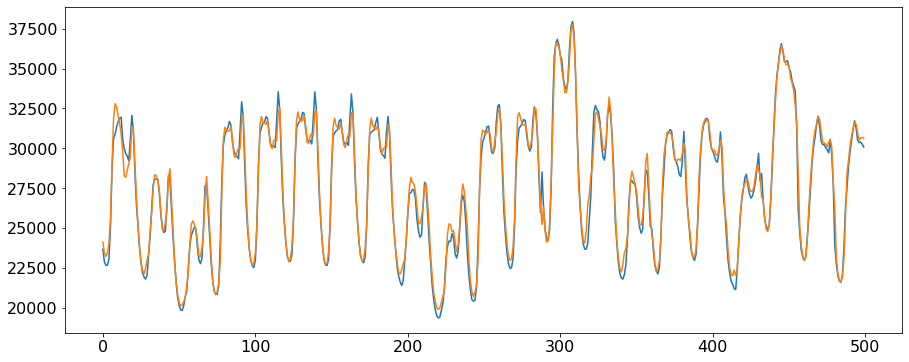

In [ ]:
points = 500

true_plot_values = true_values[:points]
pred_plot_values = pred_values[:points]

plt.figure(figsize=(15,6))
plt.plot(range(true_plot_values.__len__()), true_plot_values)
plt.plot(range(pred_plot_values.__len__()), pred_plot_values)

##Comparación con otros modelos de predicción.

En esta sección se compara el rendimiento del modelo con otros regresores clásicos que realizan este trabajo.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


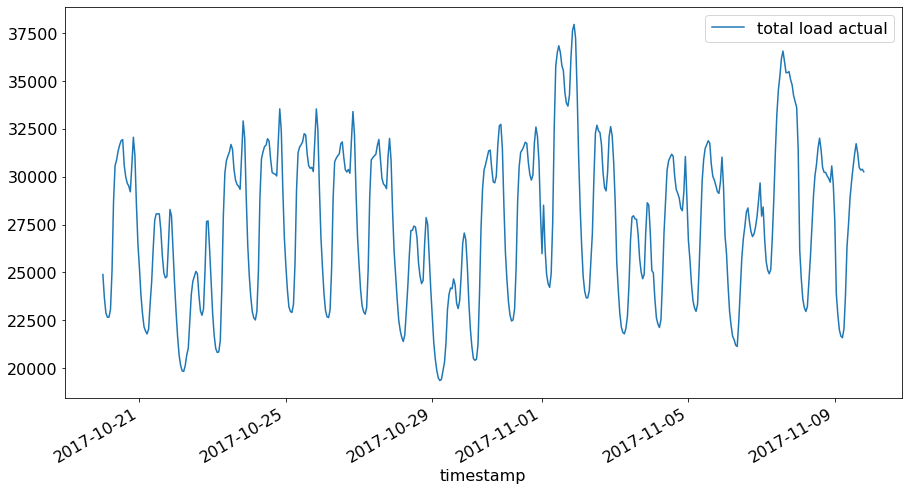

In [ ]:
df_energy_test['timestamp'] = pd.to_datetime(df_energy['timestamp'], format='%Y-%m-%d %H:%M:%S')

df_energy_test.iloc[:500].plot(x='timestamp', figsize=(15,8))

###Red Neuronal

In [ ]:
# Función para la generación de series temporales, cuyo largo se puede configurar.

def series_constructor(df, len_serie, column_serie, n_data, column_concat_name=None, dropna=True, reset_index=True):
  df_process = df[column_serie]
  df_out = pd.DataFrame() if column_concat_name == None else df[column_concat_name]
  for k in reversed(range(len_serie + 1)):
    serie_moved = df_process.shift(k)
    serie_moved.name = 't-' + str(k)
    df_out = pd.concat([df_out, serie_moved], axis=1)
  df_out.rename(columns={'t-0':'t'}, inplace=True)
  columns_final = list(df_out.columns) if column_concat_name == None else list(df_out.columns)[1:] + [column_concat_name]
  df_out = df_out[columns_final]
  df_out.dropna(inplace=dropna)
  df_out = df_out.iloc[:n_data]
  df_out.reset_index(drop=reset_index, inplace=reset_index)
  return df_out